# Code to work with SK elevations

In [7]:
import pandas as pd
import numpy as np
import datetime
import os
import fiona
import rasterio as rio
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from scipy import stats
import cmocean

# 1) Choose centerline file

In [70]:
# load the centerline file ########################
clinepath = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/centerlines/'
for file in os.listdir(clinepath):
    if file.endswith('.shp'):
        print(file)
cfile = 'centerline_n_utm07_500m_circlebuffer.shp'
########################################################
print(); print(cfile, 'CHOSEN')

if cfile.split('_')[1] == 'n':
    northline = True
    newfolder = 'centerline-north'
elif cfile.split('_')[1] == 's':
    northline = False
    newfolder = 'centerline-south'
else:
    print('Check filename:')
    print(cfile.split('_'))
print(newfolder)
spacing = cfile.split('_')[3]
print(spacing)

# read with geopandas
cline_gdf = gpd.read_file(clinepath+cfile)
geoms = cline_gdf.geometry.values
cline_gdf

centerline_s_utm07_250m_squarebuffer.shp
centerline_n_utm07_250m_circlebuffer.shp
centerline_n_utm07_250m.shp
centerline_n_utm07_250m_squarebuffer.shp
centerline_s_utm07_250m_circlebuffer.shp
centerline_s_utm07_500m_circlebuffer.shp
centerline_n_utm07_500m_circlebuffer.shp
centerline_n_utm07_121pts.shp
centerline_n_utm07_500m.shp
centerline_n_final_wgs84.shp
centerline_s_final_wgs84.shp
centerline_n_final_utm07.shp
centerline_s_final_utm07.shp
centerline_s_utm07_250m.shp

centerline_n_utm07_500m_circlebuffer.shp CHOSEN
centerline-north
500m


,id,distance,angle,geometry
0,None,0.0,120.762720,"POLYGON ((560899.262 6672656.883, 560887.026 6..."
1,None,500.0,120.762720,"POLYGON ((561328.909 6672401.141, 561316.673 6..."
2,None,1000.0,111.317912,"POLYGON ((561777.686 6672184.553, 561765.450 6..."
3,None,1500.0,106.858399,"POLYGON ((562246.083 6672010.320, 562233.847 6..."
4,None,2000.0,113.629378,"POLYGON ((562721.173 6671856.036, 562708.937 6..."
...,...,...,...,...
56,None,28000.0,119.124053,"POLYGON ((577652.493 6654803.399, 577640.257 6..."
57,None,28500.0,116.861918,"POLYGON ((578096.990 6654574.559, 578084.754 6..."
58,None,29000.0,119.116146,"POLYGON ((578538.770 6654340.605, 578526.534 6..."
59,None,29500.0,118.610460,"POLYGON ((578975.645 6654097.419, 578963.409 6..."


# 2) Extract elevations at 250 m resolution (choose 250m centerline)

In [165]:
dem_path = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/final-DEMs/'
dem_outpath = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/'
prof_count = 0

In [74]:
# pull DEM elevations
for file in os.listdir(dem_path):
    if file.endswith('.tif'):
    
        ds = file.split('_')[0]
        print(ds)
        
        # open DEM
        src = rio.open(dem_path+file); elev = src.read(1); affine=src.transform
        
        # extract mean elevations
        dists = []; mean_elev = []
        for idx2, row2 in cline_gdf.iterrows():
            geom = row2.geometry
            dist = row2.distance
            dists.append(dist)
            try:
                out_image, out_transform = mask(src, [mapping(geom)], crop=True)
                crop_array = out_image[0,:,:]
                crop_array[crop_array < -1e3] = np.NaN
#                 print(dist, np.nanmean(crop_array))
                mean_elev.append(np.nanmean(crop_array))
            except Exception:
                mean_elev.append(np.NaN)
#                 print(dist, 'no overlap')
                pass
        mean_elev = np.array(mean_elev); dists = np.array(dists)
        if northline: # flip distances for northern centerline
            dists = np.flip(dists)
            
        
        mean_elev[mean_elev == 0] = np.NaN # differences should never be exactly 0
#         plt.plot(dists/1000, mean_elev, 'o')
#         plt.xlim(0, 30)
#         plt.show()
        
        # write centerline data to csv
        new_df = pd.DataFrame(list(zip(dists, mean_elev)), columns=['dist_m','mean_elev'])
        new_df.to_csv(dem_outpath+'centerline_'+cfile.split('_')[1]+'_'+spacing+'_'+ds+'.csv')
        
        prof_count+=1
# os.listdir(dem_path)

20140318


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_53426/2613793218.py:22: RuntimeWarning: Mean of empty slice
  mean_elev.append(np.nanmean(crop_array))


20220223
20180128
20180117
201801me
20220421
20220522
20120826
20190430
20161019
bed
20151031
h.tif
herr.tif
20131207
20180507
20200605
20160717
20170712
20210717
20211025


## Plot centerline elevation profiles

In [ ]:
# add code to plot centerline elevations from other script

# 3) Calculate surface slope

2012-08-26 0.045472163609022564
2013-12-07 0.041808837890625
2014-03-18 0.04216386209478506
2015-10-31 0.049203723818181826
2016-07-17 0.05015843041664382
2017-07-12 0.0438416359289132
2018-01-28 0.04845387846085607
2018-05-07 0.0496350429458701
2019-04-30 0.05131985223239917
2020-06-05 0.045189963077238555
2021-07-17 0.03851160556154554
2021-10-25 0.042447464792351966
2022-05-22 0.04327917398657775
0.04549889498577005


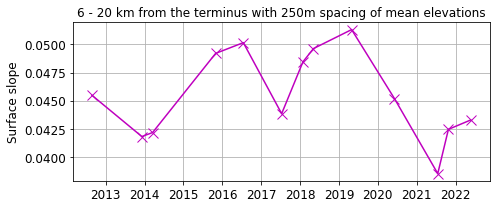

In [167]:
####################
outfigpath = '/Users/jukesliu/Documents/TURNER/DATA/figures/'
filelist = os.listdir(dem_outpath); filelist.sort()
# spatial extent for calculation of surface slope [km from terminus]:
EXTENT_START = 6
EXTENT_END = 20
###################

# plot fontsize and colors
fs = 12 # figure fontsize
colors = plt.cm.viridis_r(np.linspace(0,1,prof_count))
col_count = 0

date_list = []; slopes = []
for elevprofile in filelist:
    if elevprofile.startswith('centerline_n_250m') and elevprofile.endswith('.csv') and '20' in elevprofile:
        elev_df = pd.read_csv(dem_outpath+elevprofile)
        ds = elevprofile.split('_')[-1][:-4]
        
        if 'me' in ds or 'xx' in ds:
            day = '15' # replace the day with a generic half point in the month
        else:
            day = ds[6:8]
        ds_leg = ds[0:4]+'-'+ds[4:6]+'-'+day
#         print(ds_leg)
        
    
        # EVALUATE SURFACE SLOPE AND PLOT
        if ds_leg != '2018-01-17' and ds_leg != '2018-01-15' and not ds_leg.startswith('2022-04')  and not ds_leg.startswith('2022-02') and ds_leg !='2016-10-19': # incomplete
            surface_slope_df = elev_df[(elev_df.dist_m > EXTENT_START*1000) 
                                       & (elev_df.dist_m < EXTENT_END*1000)] # between 1 and 16 km
            nanmask = ~np.isnan(surface_slope_df.mean_elev)
            
            if len(surface_slope_df.mean_elev[nanmask]) == 0:
                continue
            
            slope, intercept, r, p, std_err = stats.linregress(surface_slope_df.dist_m[nanmask], 
                                                               surface_slope_df.mean_elev[nanmask])  
            print(ds_leg, slope)
            slopes.append(slope)
            date_list.append(ds_leg)
            
#             fig, ax = plt.subplots(1)
#             ax.plot(surface_slope_df.dist_m[nanmask],surface_slope_df.mean_elev[nanmask], 'o')
#             ax.plot(surface_slope_df.dist_m[nanmask], slope*surface_slope_df.dist_m[nanmask] + intercept, '--')
#             ax.grid()
#             plt.show()
    
#         # save a figure:
#         plt.savefig(outfigpath+'elev_profile_nterm_'+ds+'.png',dpi=200)
            
        col_count+=1
        
# background_col='xkcd:white'; ax.set_facecolor(background_col)
# plt.gca().axes.get_xaxis().set_ticklabels([])
# plt.legend(date_list,ncol=3,loc='lower right',fontsize=fs, framealpha=1) # legend
plt.figure(figsize=(7,3))
plt.plot(pd.to_datetime(date_list), slopes, 'mx-', markersize=10)
plt.ylabel('Surface slope', fontsize=fs)
plt.title(str(EXTENT_START)+' - '+str(EXTENT_END)+' km from the terminus with 250m spacing of mean elevations')
plt.grid()
plt.tick_params(labelsize=fs)
plt.tight_layout()

ss_df = pd.DataFrame(list(zip(date_list, slopes)), columns=['datetime','slope'])
# ss_df.to_csv(outfigpath+'surface_slopes_0to7km.csv')

print(np.nanmean(slopes))

plt.show()

In [168]:
ss_df

,datetime,slope
0,2012-08-26,0.045472
1,2013-12-07,0.041809
2,2014-03-18,0.042164
3,2015-10-31,0.049204
4,2016-07-17,0.050158
5,2017-07-12,0.043842
6,2018-01-28,0.048454
7,2018-05-07,0.049635
8,2019-04-30,0.051320
9,2020-06-05,0.045190


In [169]:
ds1s = ['20120826','20131207','20140318','20151031','20160717','20170712','20180128','20190430','20200605','20210717']
ds2s = ['20131207','20140318','20151031','20160717','20170712','20180128','20190430','20200605','20210717','20220522']
slope_changes = [0.041809 - 0.045472, # 2013-2012
                 0.042164 - 0.041809, # 2014-2013
                 0.049204 - 0.042164, # 2015-2014
                 0.050158 - 0.049204, # 2016-2015
                 0.043842 - 0.050158, # 2017-2016
                 0.048454 - 0.043842, # 2018-2017
                 0.051320 - 0.048454, # 2019-2018
                 0.045190 - 0.051320, # 2020-2019
                 0.038512 - 0.045190, # 2021-2020
                 0.043279 - 0.038512] # 2022-2021

ss_td_df = pd.DataFrame(list(zip(ds1s, ds2s, slope_changes)),columns=['ds1','ds2','slope_change'])
ss_td_df

,ds1,ds2,slope_change
0,20120826,20131207,-0.003663
1,20131207,20140318,0.000355
2,20140318,20151031,0.007040
3,20151031,20160717,0.000954
4,20160717,20170712,-0.006316
5,20170712,20180128,0.004612
6,20180128,20190430,0.002866
7,20190430,20200605,-0.006130
8,20200605,20210717,-0.006678
9,20210717,20220522,0.004767


# 4) Extract elevation differences:

In [239]:
dem_diff_path = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/final-DEMs/differenced_DEMs/upper_glacier/'

# grab differenced DEM info:
ds1s = []; ds2s = []; fnames = []
for file in os.listdir(dem_diff_path):
    if file.endswith('.tif'):
        split = file.split('_') # split filename
        ds1 = split[0]; ds2 = split[1]
        
        if ds2.endswith('.tif'):
            ds2 = ds2[:-4] # remove extension
        ds2s.append(ds1); ds1s.append(ds2); fnames.append(file)
        
dem_df = pd.DataFrame(list(zip(ds1s, ds2s, fnames)), columns=['ds1','ds2','fname'])
dem_df = dem_df.sort_values(by='ds1'); dem_df.reset_index(drop=True)

,ds1,ds2,fname
0,20120826,20131207,20131207_20120826.tif
1,20131207,20140318,20140318_20131207.tif
2,20140318,20151031,20151031_20140318.tif
3,20151031,20160717,20160717_20151031.tif
4,20160717,20170712,20170712_20160717.tif
5,20170712,20180128,20180128_20170712_2018merged.tif
6,20180128,20190430,20190430_20180128_2018merged.tif
7,20190430,20200605,20200605_20190430.tif
8,20200605,20210717,20210717_20200605.tif
9,20210717,20220522,20220522_20210717.tif


20151031_20131207.tif
20140318_20131207.tif
20160717_20131207.tif
20200605_20131207.tif
20220522_20131207.tif


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_53426/4089570575.py:18: RuntimeWarning: Mean of empty slice
  mean_diffs.append(np.nanmean(crop_array))


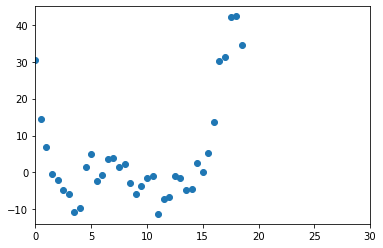

61
201801me_20131207.tif
20170712_20131207.tif
20190430_20131207.tif
20210717_20131207.tif
20200605_20140318.tif
201801me_20140318.tif
20170712_20140318.tif
20190430_20140318.tif
20210717_20140318.tif
20151031_20140318.tif
20160717_20140318.tif


In [233]:
for idx, row in dem_df.iterrows():
    print(row.fname)
    ds1 = row.ds1; ds2 = row.ds2
    
    if not os.path.exists(dem_diff_path+newfolder+'/profile_'+row.ds1+'_'+row.ds2+'.csv'):
        src = rio.open(dem_diff_path+row.fname); elev_diff = src.read(1); affine=src.transform # open it
        
        dists = []; mean_diffs = []
        for idx2, row2 in cline_gdf.iterrows():
            geom = row2.geometry
            dist = row2.distance
            dists.append(dist)
            try:
                out_image, out_transform = mask(src, [mapping(geom)], crop=True)
                crop_array = out_image[0,:,:]
                crop_array[crop_array < -1e30] = np.NaN
#                 print(dist, np.nanmean(crop_array))
                mean_diffs.append(np.nanmean(crop_array))
            except Exception:
                mean_diffs.append(np.NaN)
#                 print(dist, 'no overlap')
                pass
        mean_diffs = np.array(mean_diffs); dists = np.array(dists)
    
#         # calculate change in driving stress from elevation differences
#         slope_change = float(ss_td_df[(ss_td_df.ds1 == ds1) & (ss_td_df.ds2 == ds2)].slope_change)
#         rho = 917 # kg/m3
#         g = 9.81 #m/s2
#         driving_stress = rho*g*mean_diffs*slope_change
        
        if northline: # flip distances for northern centerline
            dists = np.flip(dists)
        mean_diffs[mean_diffs == 0] = np.NaN # differences should never be exactly 0
        plt.plot(dists/1000, mean_diffs, 'o')
        plt.xlim(0, 30)
        plt.show()
        
#         # write centerline data to csv
#         new_df = pd.DataFrame(list(zip(dists, mean_diffs, driving_stress)), 
#                               columns=['dist_m','mean_elev_diff', 'change_td_Pa'])
        
        # write centerline data to csv
        new_df = pd.DataFrame(list(zip(dists, mean_diffs)), 
                              columns=['dist_m','mean_elev_diff'])
        print(len(new_df))
        new_df.to_csv(dem_diff_path+newfolder+'/profile_'+row.ds1+'_'+row.ds2+'.csv')   

# Generate plots

## Plot all elevation difference profiles colored by year

In [274]:
# grab the profiles in order
filenames = []
nofiles = 0 # number of files
# for file in os.listdir(dem_diff_path+newfolder): # Sequential elevation differences
for file in os.listdir(dem_diff_path+newfolder): # Sequential elevation differences
    if file.startswith('profile') and file.endswith('csv'):
        filenames.append(file)
        nofiles+=1
filenames.sort()
filenames

['profile_20120826_20131207.csv',
 'profile_20131207_20140318.csv',
 'profile_20140318_20151031.csv',
 'profile_20151031_20160717.csv',
 'profile_20160717_20170712.csv',
 'profile_20170712_20180128.csv',
 'profile_20180128_20190430.csv',
 'profile_20190430_20200605.csv',
 'profile_20200605_20210717.csv',
 'profile_20210717_20220522.csv']

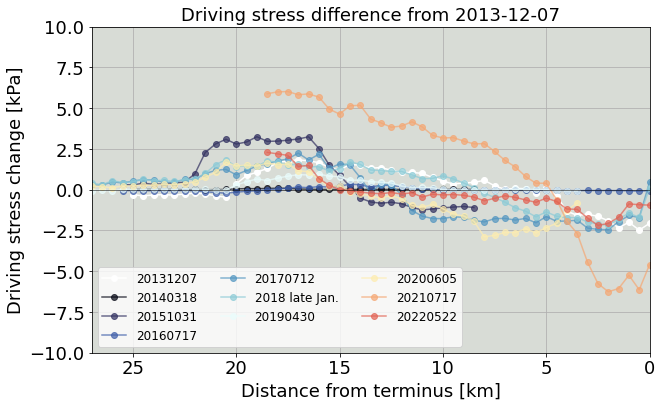

In [286]:
fig, ax = plt.subplots(figsize=(10,6))
fs = 18
alpha = 0.7
# background_col='xkcd:pale grey'
background_col='xkcd:light grey'
# ax.set_facecolor(background_col)
colors_cold = cmocean.cm.ice(np.linspace(0,1,6))
colors_warm = cmocean.cm.matter(np.linspace(0,1,6))

legends = []
a = 0
b = 0
for filename in filenames:
#     if filename.startswith('profile_2013'): # only use this conditional for total quiescent
        [pre, ds1, ds2] = filename.split('_') # grab dates
        ds2 = ds2[:-4] # cut off the .csv
        timeperiod = ds1+' to '+ds2
    #     legends.append(timeperiod)
        if ds2.startswith('2018'):
            ds2 = ('2018 late Jan.')
        legends.append(ds2)
        slope_change = float(ss_td_df[ss_td_df.ds1 == ds1].slope_change)
        df = pd.read_csv(dem_diff_path+newfolder+'/'+filename)

        if ds2.startswith('202'): # surge
#             ax.plot(df.dist_m/1000, df.mean_elev_diff, 'o-', color=colors_warm[a], alpha=alpha) # Elevation
            ax.plot(df.dist_m/1000, df.mean_elev_diff*9.81*917*slope_change/1e3, 'o-', color=colors_warm[a], alpha=alpha) # Driving Stress
            a += 1
        elif ds1.startswith('2012'): # end of the last surge
#             ax.plot(df.dist_m/1000, df.mean_elev_diff, 'o-', color='white') # Elevation
            ax.plot(df.dist_m/1000, df.mean_elev_diff*9.81*917*slope_change/1000, 'o-', color='white') # Driving stress
        else:
#             ax.plot(df.dist_m/1000, df.mean_elev_diff, 'o-', color=colors_cold[b], alpha=alpha) # Elevation
            ax.plot(df.dist_m/1000, df.mean_elev_diff*9.81*917*slope_change/1000, 'o-', color=colors_cold[b], alpha=alpha) # Driving stress
            b += 1
    
ax.set_xlim(27,0)
ax.set_xlabel('Distance from terminus [km]', fontsize=fs)
ax.plot([30, 0], [0, 0], 'k-', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_ylim(-10,10)
# ax.set_ylim(-70, 140)
ax.set_title('Driving stress difference from 2013-12-07', fontsize=fs)
ax.set_ylabel('Driving stress change [kPa]', fontsize=fs)
# ax.set_ylabel('Elevation change [m]', fontsize=fs)
ax.legend(legends, loc='lower left', ncol=3, fontsize=fs-6)
ax.grid()
ax.set_facecolor(background_col)
plt.show()       

## Plot cumulative elevation change

In [288]:
filenames

['profile_20120826_20131207.csv',
 'profile_20131207_20140318.csv',
 'profile_20140318_20151031.csv',
 'profile_20151031_20160717.csv',
 'profile_20160717_20170712.csv',
 'profile_20170712_20180128.csv',
 'profile_20180128_20190430.csv',
 'profile_20190430_20200605.csv',
 'profile_20200605_20210717.csv',
 'profile_20210717_20220522.csv']

In [289]:
# quisecence only:
filenames = filenames[:-2]
filenames = filenames[1:] 
filenames

['profile_20131207_20140318.csv',
 'profile_20140318_20151031.csv',
 'profile_20151031_20160717.csv',
 'profile_20160717_20170712.csv',
 'profile_20170712_20180128.csv',
 'profile_20180128_20190430.csv',
 'profile_20190430_20200605.csv']

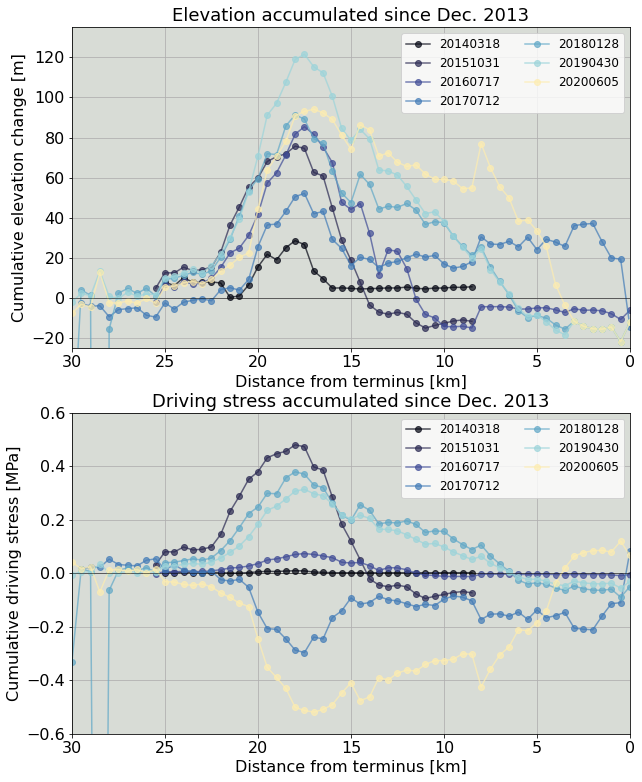

In [290]:
fig, (ax, ax2) = plt.subplots(2,1,figsize=(10,13))
fs = 16
alpha = 0.7
# background_col='xkcd:pale grey'
background_col='xkcd:light grey'
colors_cold = cmocean.cm.ice(np.linspace(0,1,7))
colors_warm = cmocean.cm.matter(np.linspace(0,1,6))

legends = []
a = 0
b = 0
c = 0
ds1s = []; ds2s = []; max_increase_driving_stress = []
for filename in filenames:
    [pre, ds1, ds2] = filename.split('_') # grab dates
    ds2 = ds2[:-4] # cut off the .csv
    timeperiod = ds2
    legends.append(timeperiod)
    
    # grab the slope change
    slope_change = float(ss_td_df[ss_td_df.ds1 == ds1].slope_change)
      
    df = pd.read_csv(dem_diff_path+newfolder+'/'+filename)
    if c == 0:
        elev_diff = np.array(df.mean_elev_diff)
        elev_diff[np.isnan(elev_diff)] = 0
        cumulative_elev_diff = elev_diff
#     elif ds1 == '20180128':
#         print(elev_diff)
    else:
        elev_diff = np.array(df.mean_elev_diff)
        elev_diff[np.isnan(elev_diff)] = 0
        cumulative_elev_diff = cumulative_elev_diff + elev_diff
    max_driving_stress = np.nanmax(elev_diff*9.81*917); 
    max_increase_driving_stress.append(max_driving_stress); ds1s.append(ds1); ds2s.append(ds2)
    nan_cumulative_elev = cumulative_elev_diff.copy() # copy the cumulative_elev_diff
    nan_cumulative_elev[cumulative_elev_diff == 0] = np.NaN
#     ax.plot(df.dist_m/1000, cumulative_elev_diff, 'o-', color=colors[a])

    if ds2.startswith('202'): # surge
        ax.plot(df.dist_m/1000, nan_cumulative_elev, 'o-', color=colors_warm[a], alpha=alpha) # 
        ax2.plot(df.dist_m/1000, nan_cumulative_elev*9.81*917*slope_change/10000, 'o-', color=colors_warm[a],alpha=alpha)
        a += 1
    elif ds1.startswith('2012'): # end of the last surge
        ax.plot(df.dist_m/1000, nan_cumulative_elev, 'o-', color='white') # # Elevation
    else:
        ax.plot(df.dist_m/1000, nan_cumulative_elev, 'o-', color=colors_cold[b], alpha=alpha) 
        ax2.plot(df.dist_m/1000, nan_cumulative_elev*9.81*917*slope_change/10000, 'o-', color=colors_cold[b],alpha=alpha)
        b += 1
    c += 1
ax.set_xlim(30,0)
ax.plot([30, 0], [0, 0], 'k-', linewidth=0.5);
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_ylim([-25,135])
ax.set_ylabel('Cumulative elevation change [m]', fontsize=fs)
ax.set_xlabel('Distance from terminus [km]', fontsize=fs)
ax.legend(legends, loc='upper right', ncol=2, fontsize=fs-4) 

ax2.set_xlim(30,0)
ax2.set_ylim(-0.6,0.6)
ax2.tick_params(axis='both', which='major', labelsize=fs)
ax2.plot([30, 0], [0, 0], 'k-', linewidth=0.5)
ax2.set_xlabel('Distance from terminus [km]', fontsize=fs)
ax2.set_ylabel('Cumulative driving stress [MPa]', fontsize=fs)
ax2.legend(legends, loc='upper right', ncol=2, fontsize=fs-4)


ax.grid(); ax2.grid()
ax.set_facecolor(background_col); ax2.set_facecolor(background_col)
ax.set_title('Elevation accumulated since Dec. 2013',fontsize=fs+2)
ax2.set_title('Driving stress accumulated since Dec. 2013',fontsize=fs+2)
# fig.savefig(dem_outpath+'figures/cumulative_driving_stress_quiescence_wslope.png', dpi=200)
plt.show()       

In [196]:
# # driving stress
# max_ds_df = pd.DataFrame(list(zip(ds1s, ds2s, max_increase_driving_stress)), columns=['ds1','ds2','max_increase_ds_kPa'])
# max_ds_df


In [195]:
# fig, ax = plt.subplots(figsize=(10,5))
# for idx, row in max_ds_df.iterrows():
#     d1 = datetime.datetime.strptime(row.ds1, '%Y%m%d')
#     d2 = datetime.datetime.strptime(row.ds2, '%Y%m%d')
#     ax.plot([d1, d2], [row.max_increase_ds_kPa, row.max_increase_ds_kPa],'k-',linewidth=3)

# ax.grid()
# ax.tick_params(axis='both',labelsize=fs)
# ax.set_ylabel('Driving stress increase [kPa]', fontsize=fs)
# fig.savefig(dem_outpath+'figures/increase_driving_stress_quiescence_noslope.png', dpi=200)
# plt.show()

## Plot one driving stress profile

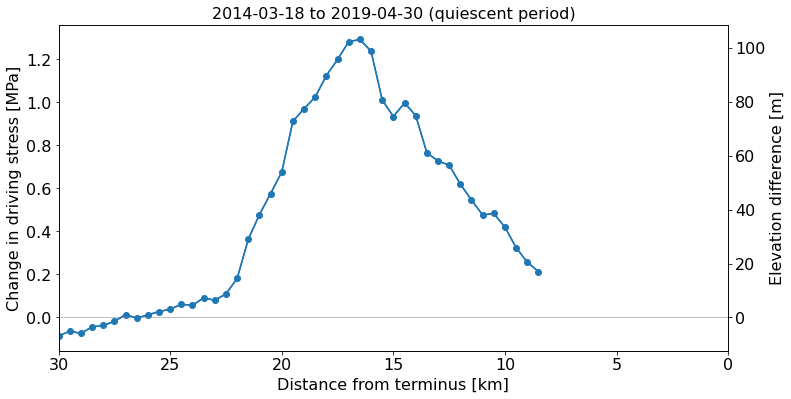

In [436]:
prof_df = pd.read_csv(dem_diff_path+newfolder+'/total_quiescent/profile_20140318_20190430.csv')
fs = 16

fig, ax = plt.subplots(figsize=(12,6))
twin1 = ax.twinx()

ax.plot(prof_df.dist_m/1000, prof_df.change_in_driving_stress_Pa*(0.053484 - 0.039550)/10000, 'o-')
ax.plot([30, 0], [0, 0], '-', color='gray',linewidth=0.5)
# plt.plot([30, 0], [0, 0], '-', color='gray',linewidth=0.5)
ax.set_ylabel('Change in driving stress [MPa]',fontsize=fs)
ax.set_xlabel('Distance from terminus [km]',fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
plt.title('2014-03-18 to 2019-04-30 (quiescent period)', fontsize=fs)
ax.set_xlim(30,0)

twin1.plot(prof_df.dist_m/1000, prof_df.mean_elev_diff,'-')
twin1.set_ylabel('Elevation difference [m]',fontsize=fs)
twin1.tick_params(axis='both', which='major', labelsize=fs)
fig.savefig(dem_outpath+'figures/total_driving_stress_quiescence_wslope.png', dpi=200)
plt.show()

## Plot bed elevations:

In [212]:
# sIPR
sIPR_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/bed/sIPR/sIPR_proj_data.csv')
sIPR_df.head()

,sIPR_UTMx_proj,sIPR_UTMy_proj,sIPR_dist_km_proj,Pick_depth
0,570661.311252,6.658280e+06,0.357101,-357.03
1,570662.688259,6.658279e+06,1.936953,-356.68
2,570664.025658,6.658278e+06,3.471361,-356.68
3,570666.759973,6.658277e+06,6.608462,-356.68
4,570668.075655,6.658276e+06,8.117954,-356.00


In [279]:
# Millan
Millan_surf_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/centerline_n_500m_201801me.csv',
                            names=['idx','dist_m','surface_elev'],usecols=[1,2],skiprows=1)
Millan_h_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/centerline_n_500m_h.tif.csv',
                         names=['idx','dist_m','h'],usecols=[1,2],skiprows=1)
Millan_herr_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/centerline_n_500m_herr.tif.csv',
                            names=['idx','dist_m','h_err'],usecols=[1,2],skiprows=1)
# Millan_surf_df
Millan_h_df

,dist_m,h
0,30000.0,137.667680
1,29500.0,136.348110
2,29000.0,133.358860
3,28500.0,152.587420
4,28000.0,153.254640
...,...,...
56,2000.0,123.974690
57,1500.0,77.235860
58,1000.0,50.157630
59,500.0,59.913498


In [280]:
Millan_merged_df = Millan_surf_df.merge(Millan_h_df,on='dist_m').merge(Millan_herr_df,on='dist_m')
Millan_merged_df

,dist_m,surface_elev,h,h_err
0,30000.0,1792.532600,137.667680,36.644627
1,29500.0,1812.937700,136.348110,36.743800
2,29000.0,1763.221400,133.358860,36.256200
3,28500.0,916.924130,152.587420,37.214874
4,28000.0,1709.350500,153.254640,36.272728
...,...,...,...,...
56,2000.0,157.659410,123.974690,36.330578
57,1500.0,123.163890,77.235860,29.776860
58,1000.0,89.217220,50.157630,25.785124
59,500.0,68.544650,59.913498,26.396694


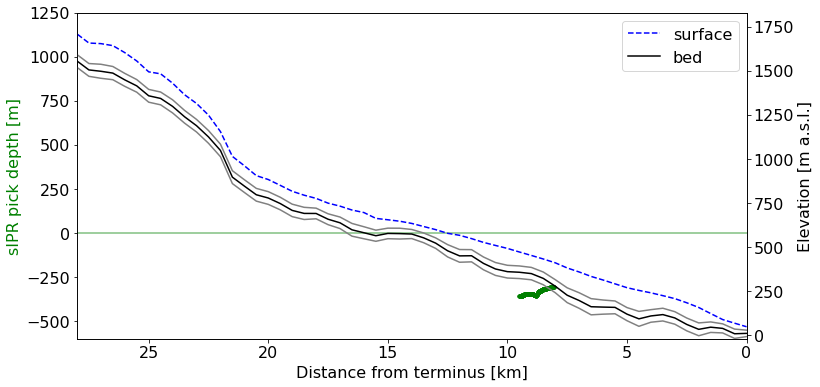

In [308]:
fs = 16
fig, ax = plt.subplots(figsize=(12,6))
twin1 = ax.twinx()

# sIPR transect begins at 9.5 km from terminus
ax.plot(9.5-sIPR_df.sIPR_dist_km_proj/1000, sIPR_df.Pick_depth, 'g.-') # sIPR
ax.plot([30, 0],[0,0],'g-',alpha=0.5)

# Millan:
twin1.plot(Millan_merged_df.dist_m/1000, Millan_surf_df.surface_elev, 'b--') # surface
twin1.plot(Millan_merged_df.dist_m/1000, Millan_merged_df.surface_elev - Millan_merged_df.h, 'k-') # bed elev
# error bars on bed elev:
twin1.plot(Millan_merged_df.dist_m/1000, 
           Millan_merged_df.surface_elev - Millan_merged_df.h - Millan_merged_df.h_err,'-',color='gray')
twin1.plot(Millan_merged_df.dist_m/1000, 
           Millan_merged_df.surface_elev - Millan_merged_df.h + Millan_merged_df.h_err,'-',color='gray',)

# plot params
ax.set_ylabel('sIPR pick depth [m]',color='g',fontsize=fs)
twin1.set_ylabel('Elevation [m a.s.l.]',fontsize=fs)
twin1.legend(['surface','bed'],fontsize=fs)
twin1.tick_params(axis='both', which='major', labelsize=fs)
ax.set_ylim(-600,1850-600)
twin1.set_ylim(-20, 1830)
ax.set_xlabel('Distance from terminus [km]',fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_xlim(28,0)
# ax.grid()

# twin1.plot(prof_df.dist_m/1000, prof_df.mean_elev_diff,'-')
# twin1.set_ylabel('Elevation difference [m]',fontsize=fs)
# twin1.tick_params(axis='both', which='major', labelsize=fs)
plt.show()